In [3]:
import time
from typing import List, Optional, Any
import numpy as np
import matplotlib.pyplot as plt

from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram
from qiskit.optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer

/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,
/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimizat

In [4]:
# define COBYLA optimizer to handle convex continuous problems.
cobyla = CobylaOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend('statevector_simulator')))

# exact QUBO solver as classical benchmark
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver()) # to solve QUBOs

# in case CPLEX is installed it can also be used for the convex problems, the QUBO,
# or as a benchmark for the full problem.
#
# cplex = CplexOptimizer()

/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')
/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:72: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit-terra')
/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstanc

In [5]:
# construct model using docplex
mdl = Model('ex6')

v = mdl.binary_var(name='v')
w = mdl.binary_var(name='w')
t = mdl.binary_var(name='t')
u = mdl.continuous_var(name='u')

mdl.minimize(v + w + t + 5 * (u-2)**2)
mdl.add_constraint(v + 2 * w + t + u <= 3, "cons1")
mdl.add_constraint(v + w + t >= 1, "cons2")
mdl.add_constraint(v + w == 1, "cons3")

# load quadratic program from docplex model
qp = QuadraticProgram()
qp.from_docplex(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: ex6

Minimize
 obj: v + w + t - 20 u + [ 10 u^2 ]/2 + 20
Subject To
 cons1: v + 2 w + t + u <= 3
 cons2: v + w + t >= 1
 cons3: v + w = 1

Bounds
 0 <= v <= 1
 0 <= w <= 1
 0 <= t <= 1

Binaries
 v w t
End



### Classical Solution

In [6]:
admm_params = ADMMParameters(
                            rho_initial=1001,
                            beta=1000,
                            factor_c=900,
                            maxiter=100,
                            three_block=True, tol=1.e-6
                            )

In [7]:
# define QUBO optimizer
qubo_optimizer = exact
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params,
                     qubo_optimizer=qubo_optimizer,
                     continuous_optimizer=convex_optimizer)

In [8]:
result = admm.solve(qp)


/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


In [9]:
print("x={}".format(result.x))
print("fval={:.2f}".format(result.fval))

x=[1. 0. 0. 2.]
fval=1.00


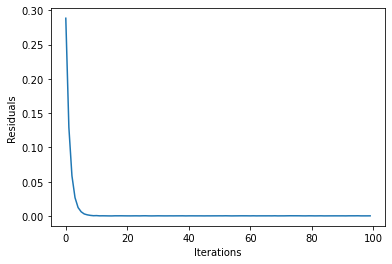

In [10]:
plt.plot(result.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

### Quantum Solution

In [11]:
# define QUBO optimizer
qubo_optimizer = qaoa

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with quantum QUBO optimizer and classical convex optimizer
admm_q = ADMMOptimizer(params=admm_params,
                       qubo_optimizer=qubo_optimizer,
                       continuous_optimizer=convex_optimizer)

In [12]:
result_q = admm_q.solve(qp)


/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/aqua/components/variational_forms/variational_form.py:48: DeprecationWarning: The package qiskit.aqua.components.variational_forms is deprecated. For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.variational_forms')
/Users/pbaweja/opt/miniconda3/envs/admm/lib/python3.6/site-packages/qiskit/aqua/algorithms/quantum_algorithm.py:46: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return aqua_globals.random


In [13]:
print("x={}".format(result_q.x))
print("fval={:.2f}".format(result_q.fval))

x=[1. 0. 0. 2.]
fval=1.00


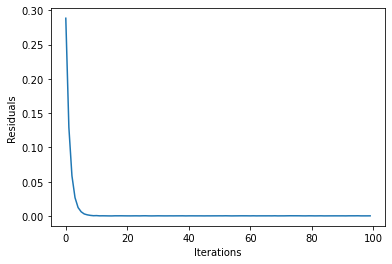

In [14]:
plt.clf()
plt.plot(result_q.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()